In [1]:
import pyscf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tn4qa.dmrg import DMRG
from tn4qa.qi_metrics import get_all_mutual_information
from tn4qa.utils import ham_dict_from_scf

def get_mi_matrix(mf : pyscf.scf.RHF):
    ham = ham_dict_from_scf(mf, qubit_transformation="JW")
    dmrg = DMRG(
        hamiltonian=ham,
        max_mps_bond=16,
        method="one-site"
    )
    dmrg.run(10)
    mi = get_all_mutual_information(dmrg.mps)
    return mi

In [ ]:
# xyz_path = "/Users/tom/Documents/ucl/xyz_bin/webmo_geom_opt/HF_STO-3G/phosphate.xyz"
xyz_path = "H 0 0 0; H 0 0 1"
basis = ""

mol = pyscf.M(
    atom=xyz_path,
    basis=basis,
)

mf = pyscf.scf.RHF(mol).run(verbose=0)

norb = mol.nao
nocc = np.count_nonzero(mf.mo_occ)
nvir = mol.nao - np.count_nonzero(mf.mo_occ)

print(mol.nelectron, 'electrons in', norb, 'orbitals')
print(nocc, 'occupied,', nvir, 'virtual')

14 electrons in 10 orbitals
7 occupied, 3 virtual


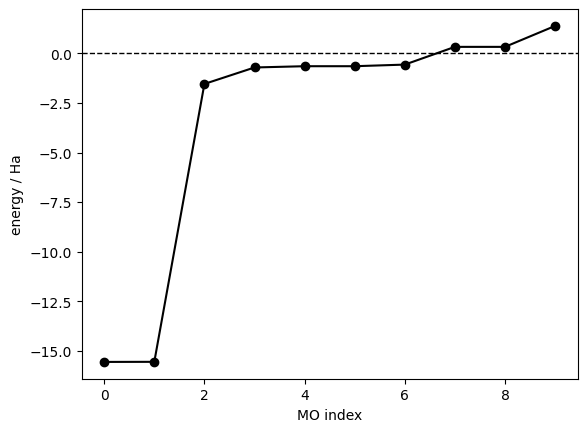

In [86]:
def orb_energies_plot(mf, savepath=None):
    plt.plot(mf.mo_energy, 'ko-')
    plt.axhline(0, color='k', lw=1, ls='--')
    plt.xlabel('MO index')
    plt.ylabel('energy / Ha')
    if savepath:
        plt.savefig(savepath)
    else:
        plt.show()

orb_energies_plot(mf)

In [4]:
mi_matrix = get_mi_matrix(mf)

/Users/angusmingare/Library/Caches/pypoetry/virtualenvs/tn4qa-cqx8VMJt-py3.11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `baytune (btb)`, `chocolate`, `nevergrad` or `skopt` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


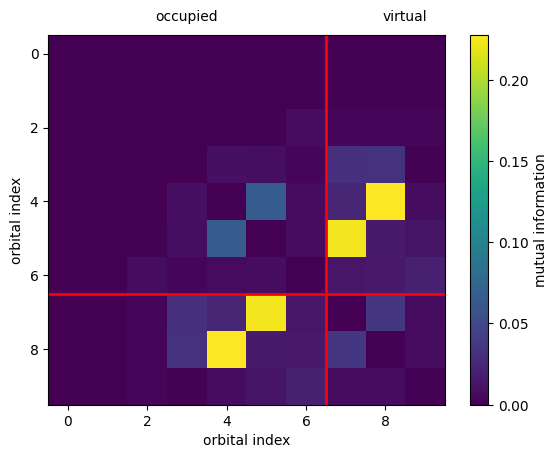

In [5]:
def mi_heatmap(mi_matrix, nocc, nvir, savepath=None):
    plt.imshow(mi_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(label='mutual information')
    plt.xlabel('orbital index')
    plt.ylabel('orbital index')
    plt.axhline(nocc - 0.5, color='r', lw=2)
    plt.axvline(nocc - 0.5, color='r', lw=2)
    plt.text(
        (nocc-1)/2,
        -1,
        'occupied',
        color='k',
        ha='center',
        va='center',
    )
    plt.text(
        nvir/2 + nocc,
        -1,
        'virtual',
        color='k',
        ha='center',
        va='center',
    )
    if savepath:
        plt.savefig(savepath)
    else:
        plt.show()

mi_heatmap(mi_matrix, nocc, nvir)

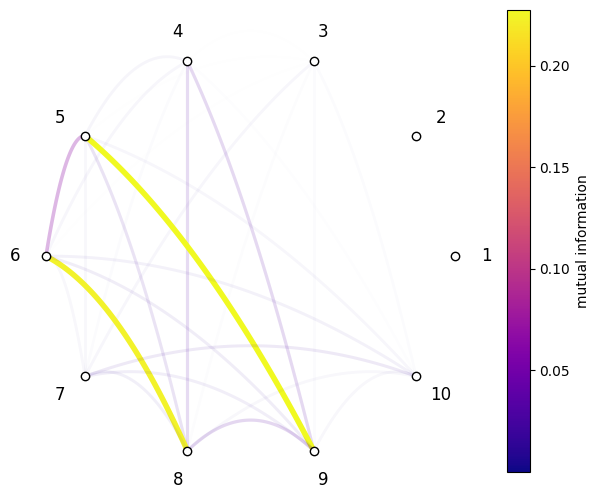

In [6]:
def mi_circular_plot(matrix, log_scale=True, cmap='plasma', savepath=None):
    N = matrix.shape[0]
    assert matrix.shape == (N, N), "Matrix must be square"
    
    # Coordinates of nodes placed on a circle
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    node_pos = np.array([(np.cos(a), np.sin(a)) for a in angles])

    # Set up plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_aspect('equal')
    ax.axis('off')

    # Normalize weights for color mapping
    weights = matrix[np.triu_indices(N, k=1)]
    weights = weights[weights > 0]
    if log_scale:
        norm = plt.Normalize(np.log10(weights.min()), np.log10(weights.max()))
        scalar_map = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        to_color = lambda w: scalar_map.to_rgba(np.log10(w))
    else:
        norm = plt.Normalize(weights.min(), weights.max())
        scalar_map = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        to_color = scalar_map.to_rgba

    # Draw edges (upper triangle only)
    for i in range(N):
        for j in range(i+1, N):
            weight = matrix[i, j]
            if weight > 0:
                x1, y1 = node_pos[i]
                x2, y2 = node_pos[j]

                # Draw a curved arc using a quadratic Bezier curve
                control = ((x1 + x2)/2, (y1 + y2)/2 + 0.3)  # offset for curvature
                path = np.array([ [x1, y1], control, [x2, y2] ])
                curve = bezier_curve(path)
                alpha = (weight - weights.min()) / (weights.max() - weights.min() + 1e-10)
                #alpha = max(0.1, alpha)  # prevent full invisibility

                ax.plot(curve[:, 0], curve[:, 1],
                        color=to_color(weight),
                        linewidth=2 + 2 * (weight / weights.max()),
                        alpha=alpha)


    # Draw nodes
    for idx, (x, y) in enumerate(node_pos):
        # Plot node
        ax.plot(x, y, 'o', color='white', markeredgecolor='black', zorder=10)

        # Offset label outward by a small amount (e.g., 10%)
        angle = angles[idx]
        offset = 0.15  # distance from the node
        x_text = x + offset * np.cos(angle)
        y_text = y + offset * np.sin(angle)

        ax.text(x_text, y_text, str(idx+1), fontsize=12,
                ha='center', va='center', zorder=11)


    # Colorbar
    scalar_map.set_array([])
    cbar = plt.colorbar(scalar_map, ax=ax, orientation='vertical')
    cbar.set_label("mutual information (log scale)" if log_scale else "mutual information")

    if savepath:
        plt.savefig(savepath)
    else:
        plt.show()

def bezier_curve(points, num=100):
    """Create a quadratic Bezier curve from 3 points."""
    p0, p1, p2 = points
    t = np.linspace(0, 1, num)[:, None]
    return (1 - t)**2 * p0 + 2*(1 - t)*t * p1 + t**2 * p2

mi_circular_plot(mi_matrix, log_scale=False)


Let's do a diatomic bond stretch and produce plots at each point:

In [90]:
Rs = np.linspace(0.8, 3, 2)
print(Rs)

[0.8 3. ]


done R = 0.8


SystemError: CPUDispatcher(<function _dot_coo_coo_type.<locals>._dot_coo_coo at 0x33e0b4cc0>) returned a result with an exception set

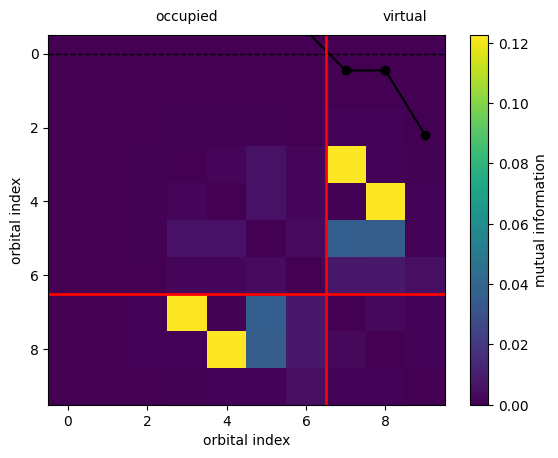

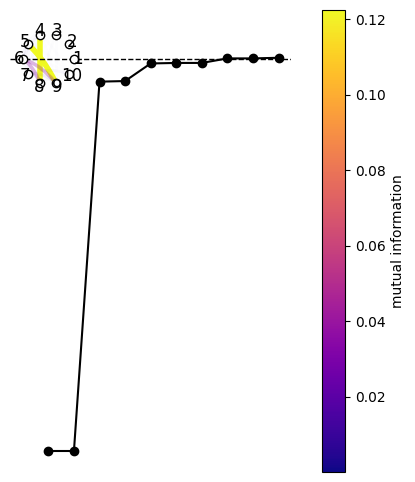

In [ ]:
for R in Rs:
    mol = pyscf.M(
        atom='N 0 0 0; N 0 0 {}'.format(R),
        basis='STO-3G',
    )
    mf = pyscf.scf.RHF(mol).run(verbose=0)
    norb = mol.nao
    nocc = np.count_nonzero(mf.mo_occ)
    nvir = mol.nao - np.count_nonzero(mf.mo_occ)

    fname = str(R) + '.png'

    orb_energies_plot(mf, savepath='figs/orb_energy_' + fname)
    plt.clf()

    mi_matrix = get_mi_matrix(mf)

    mi_heatmap(mi_matrix, nocc, nvir, savepath='figs/mi_heatmap_' + fname)
    plt.clf()

    mi_circular_plot(mi_matrix, log_scale=False, savepath='figs/mi_circular_plot_' + fname)
    plt.clf()

    print('done R =', R)